In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from split_data import X_raw_train, X_raw_val, X_raw_test, y_raw_train, y_raw_val, y_raw_test

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

# Set up Data

### Combining previous train and val data into one dataset

In [2]:
X_train = pd.concat([X_raw_train, X_raw_val])
y_train = pd.concat([y_raw_train, y_raw_val])

X_train.shape, y_train.shape

((53120, 11), (53120,))

### Sampling 100 datapoints for later use

In [3]:
# resetting index to allow for accessing rows by index
X_raw_test.reset_index(drop = True, inplace = True)
y_raw_test.reset_index(drop = True, inplace = True)

# pick out 100 datapoints from test data for use later with production model
random_indices = np.random.choice(len(X_raw_test), 100, replace = False)

# set aside samples for later
X_sample = X_raw_test.iloc[random_indices].reset_index(drop = True)
y_sample = y_raw_test.iloc[random_indices].reset_index(drop = True)

# make dataframe of samples
samples = pd.concat([X_sample, y_sample], axis = 1)

# save samples to file (used in production_model.py for final predictions)
samples.to_csv("assets/test_samples.csv", index = False)

# finally drop samples from test data
X_test = X_raw_test.drop(index = random_indices)
y_test = y_raw_test.drop(index = random_indices)

# Load in Models

In [4]:
best_lr = joblib.load("models/best_lr.pkl")
best_rf = joblib.load("models/best_rf.pkl")
best_knn = joblib.load("models/best_knn.pkl")

# Set up Pipeline

### Define steps

In [5]:
steps = [("scaler", StandardScaler()), # scale using scaler determined to be best
         ("voting", VotingClassifier(estimators = [
             ("model_logistic", best_lr), # vote based on all 3 models
             ("model_forest", best_rf), 
             ("model_knn", best_knn)],
             voting = "soft"
        ))]

### Create pipeline

In [6]:
pipeline = Pipeline(steps)

# Fit and Make Predictions

In [7]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

c:\Users\Andre\.virtualenvs\disease_prediction-YIxnrnW5\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Evaluate Model

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6670
           1       0.74      0.69      0.72      6510

    accuracy                           0.73     13180
   macro avg       0.73      0.73      0.73     13180
weighted avg       0.73      0.73      0.73     13180



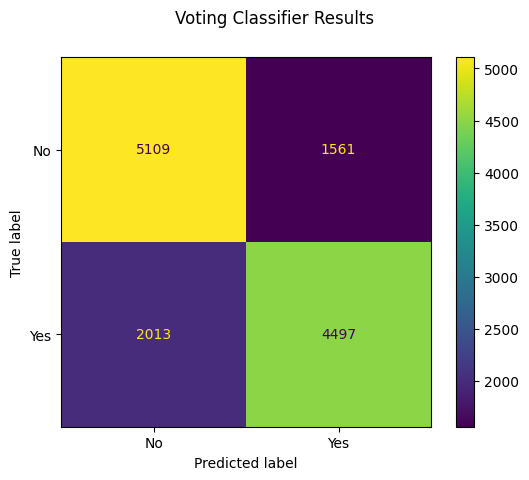

In [9]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels = ["No", "Yes"]).plot()
plt.suptitle("Voting Classifier Results");

# Finally, train on all data

### (Except the 100 samples)

In [10]:
# combine train and test
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

X.shape, y.shape

((66300, 11), (66300,))

In [11]:
# fit on full dataset
pipeline.fit(X, y)

print(pipeline) # show the steps of the pipeline

c:\Users\Andre\.virtualenvs\disease_prediction-YIxnrnW5\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('voting',
                 VotingClassifier(estimators=[('model_logistic',
                                               LogisticRegression(C=0.5,
                                                                  max_iter=4,
                                                                  random_state=42,
                                                                  solver='sag')),
                                              ('model_forest',
                                               RandomForestClassifier(criterion='entropy',
                                                                      max_features=None,
                                                                      random_state=42)),
                                              ('model_knn',
                                               KNeighborsClassifier(algorithm='ball_tree',
                                                               

# Save Model

In [12]:
joblib.dump(pipeline, "models/final_model.pkl")

['models/final_model.pkl']